## This is probably all hopeless

In [67]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

import matplotlib.pyplot as plt

product_info = pd.read_csv('../data/CatfoodProductInfo.csv')
reviews = pd.read_csv('../data/CatfoodReviewsInfo.csv')
df = reviews.join(product_info.set_index('product'), on='product',how='left')

In [68]:
df = df.dropna(axis=0,how='any')
df = df[['product','review_author','rating']]

In [69]:
df.sample(3)

,product,review_author,rating
17518,Purina Pro Plan Veterinary Diets EN Gastroente...,ZOEY,5
15581,Friskies Indoor Classic Pate Chicken Dinner Ca...,Gnat,5
34609,Wellness Complete Health Pate Chicken Entree G...,Anna,5


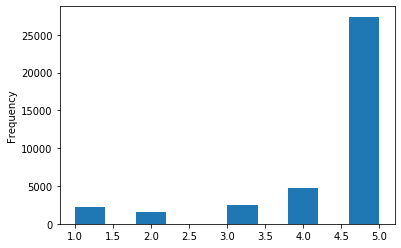

In [70]:
# Distribution of ratings
df['rating'].plot.hist()

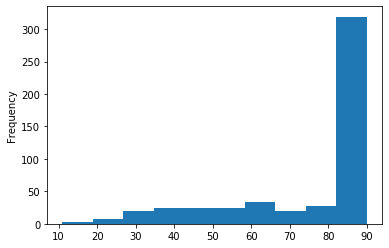

In [71]:
# Ratings per product
df['product'].value_counts().plot.hist()

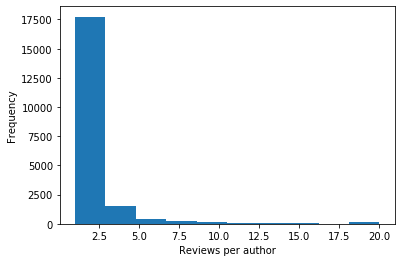

In [72]:
data = df.groupby('review_author')['rating'].count().clip(upper=20)
data.sample(5)
data.plot.hist()
plt.xlabel("Reviews per author");

In [74]:
min_product_ratings = 20
min_user_ratings = 5
max_user_ratings = 15

filter_products = df['product'].value_counts() > min_product_ratings
filter_products = filter_products[filter_products].index.tolist()

filter_users_min = df['review_author'].value_counts() > min_user_ratings
filter_users_min = filter_users_min[filter_users_min].index.tolist()

filter_users_max = df['review_author'].value_counts() < max_user_ratings
filter_users_max = filter_users_max[filter_users_max].index.tolist()

df_new = df[(df['product'].isin(filter_products)) & (df['review_author'].isin(filter_users_min)) & (df['review_author'].isin(filter_users_max))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(38351, 3)
The new data frame shape:	(4961, 3)


In [75]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_new[['review_author', 'product', 'rating']], reader)

In [76]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False) 

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([1.17025002, 1.15140285, 1.19837043]),
 'fit_time': (0.0070819854736328125,
  0.005133867263793945,
  0.0045168399810791016),
 'test_time': (0.02577519416809082, 0.019432783126831055, 0.46530604362487793)}

In [77]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.2104


1.2103727145819487

In [78]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [79]:
df.sample(5)

,uid,iid,rui,est,details,Iu,Ui,err
290,Debb,Weruva Cats in the Kitchen Pumpkin Lickin' Chi...,5.0,4.247314,{'was_impossible': False},6,8,0.752686
508,VETTEGIRL,Fancy Feast Delights with Cheddar Grilled Vari...,5.0,4.812469,{'was_impossible': False},3,10,0.187531
544,Fred,Blue Buffalo Wilderness Wild Delights Chicken ...,5.0,3.684881,{'was_impossible': False},12,10,1.315119
543,kittygirl,Fancy Feast Delights with Cheddar Grilled Turk...,5.0,4.834394,{'was_impossible': False},5,6,0.165606
418,FurFriendz,Purina Pro Plan True Nature Classic Natural Ch...,4.0,4.031790,{'was_impossible': False},6,10,0.031790


In [80]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [82]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1208,Grace,Blue Buffalo Wilderness Kitten Chicken Grain-F...,1.0,4.668434,{'was_impossible': False},4,6,3.668434
412,Tori,BFF OMG Tuna & Turkey Tickles Dinner in Gravy ...,1.0,4.668678,{'was_impossible': False},4,7,3.668678
1083,Marilyn,Hill's Prescription Diet m/d GlucoSupport with...,1.0,4.696003,{'was_impossible': False},9,6,3.696003
634,nvr2amzd,Purina Pro Plan Savor Adult Chicken & Cheese E...,1.0,4.703221,{'was_impossible': False},6,8,3.703221
138,Kathleen,Fancy Feast Flaked Trout Feast Canned Cat Food...,1.0,4.705591,{'was_impossible': False},8,6,3.705591
384,HappyMoe,Halo Whitefish Recipe Grain-Free Indoor Cat Ca...,1.0,4.802591,{'was_impossible': False},6,4,3.802591
820,Andrea,Blue Buffalo Wilderness Kitten Chicken Grain-F...,1.0,4.807457,{'was_impossible': False},12,6,3.807457
47,Christy,Hill's Prescription Diet c/d Multicare Urinary...,1.0,4.825600,{'was_impossible': False},4,5,3.825600
204,Beverly,Fancy Feast Gravy Lovers Chicken Feast in Gril...,1.0,4.848147,{'was_impossible': False},10,14,3.848147
1166,Morgan,BFF OMG Tuna & Salmon Sweet Cheeks Dinner in G...,1.0,4.893127,{'was_impossible': False},4,6,3.893127
